In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchdata
from torchtext.prototype.generate import GenerationUtils
from torchtext.models import T5Transform
from torchtext.transforms import SentencePieceTokenizer
torch.device('cuda')

from io import open
import glob
import os

0

In [3]:
def findFiles(path): 
    return glob.glob(path)
print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(all_letters)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [4]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
                   and c in all_letters
    )

In [5]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
category_lines = {}
all_categories = []

def readline(fname):
    lines = open(fname, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for fname in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(fname))[0]
    all_categories.append(category)
    lines = readline(fname)
    category_lines[category] = lines

n_categories = len(all_categories)

In [7]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [8]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters, device='cuda')
    letter_index = letterToIndex(letter)
    tensor[0][letter_index] = 1
    return tensor
# line = name, category = language
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters, device='cuda')
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [9]:
print(lineToTensor('Jonas').size())

torch.Size([5, 1, 57])


In [10]:
# Creating the RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(RNN, self).__init__()
        with torch.device('cuda'):
            self.layers = hidden_layers
            
            self.fc1 = nn.Linear(input_size+hidden_layers, hidden_layers)
            self.act1 = nn.LeakyReLU()
            self.fc2 = nn.Linear(hidden_layers, 256)
            self.act2 = nn.LeakyReLU()
            self.output = nn.Linear(256, output_size)
            self.act3 = nn.LeakyReLU()
            self.softmax = nn.LogSoftmax(1)
    
    def forward(self, inp, hidden):
        with torch.device('cuda'):
            x = torch.cat((inp, hidden), 1)
            x = hidden = self.fc1(x)
            x = self.act1(x)
            x = self.fc2(x)
            x = self.act2(x)
            x = self.output(x)
            x = self.act3(x)
            x = self.softmax(x)
        return x, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.layers, device='cuda')



In [11]:
n_hidden = 512
print(n_letters, n_hidden, n_categories)
rnn = RNN(n_letters, n_hidden, n_categories).to('cuda')

57 512 18


In [12]:
inp = lineToTensor('Jonas')
hidd = torch.zeros(1, n_hidden, device='cuda')

output, next_hidd = rnn(inp[0], hidd)
print(output)

tensor([[-2.9097, -2.8887, -2.8867, -2.8685, -2.8688, -2.9098, -2.8363, -2.9097,
         -2.9097, -2.8648, -2.8690, -2.8988, -2.9019, -2.8704, -2.9095, -2.9096,
         -2.9095, -2.9096]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 6)


In [14]:
print(categoryFromOutput(output))

('German', 6)


In [15]:
import random

def randomChoice(n):
    return n[random.randint(0, len(n)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    
    categoryTensor = torch.LongTensor([all_categories.index(category)]).to('cuda')
    line_tensor = lineToTensor(line)
    return category, line, categoryTensor, line_tensor

In [16]:
for i in range(10):
    category, line, categoryTensor, line_tensor = randomTrainingExample()
    print(category, line)

Greek Kreskas
Greek Patselas
German Schneider
Arabic Maroun
Vietnamese Le
Arabic Khoury
Vietnamese Quyen
Arabic Haik
French Deniel
Irish Desmond


In [16]:
loss_f = nn.NLLLoss()
lr = 0.015
optimizer = optim.AdamW(rnn.parameters(), lr=lr)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.last_validation_loss = None
        self.model = None
    
    def get_model(self):
        return self.model
    
    def save_model(self, model):
        self.model = model
        
    def early_stop(self, validation_loss, model):
        try:
            int(validation_loss)
            if validation_loss < self.min_validation_loss:
                self.save_model(model)
                self.min_validation_loss = validation_loss
                self.counter = 0
            elif validation_loss > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        except ValueError:
            return True
        
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    output = None
    
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = loss_f(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)
    
    return output, loss.item()

In [17]:
import time, math

n_iters = 100000
print_every = 1000
plot_every = 500

current_loss = -math.inf
all_losses = []

def timeStart(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    return '%dm %ds' % (m,s)

start = time.time()
earlyStop = EarlyStopper(patience=30000, min_delta=0.0001)

for iter in range(1, n_iters+1):
    with torch.device('cuda'):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train(category_tensor, line_tensor)
        
        current_loss += loss
        
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeStart(start), loss, line, guess, correct))
    
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
        
        decide = earlyStop.early_stop(loss, rnn)
        if decide:
            print('Early stopping')
            break

1000 1% (0m 2s) 2.9039 Xing / Polish ✗ (Chinese)
2000 2% (0m 6s) 2.8455 Hofwegen / Spanish ✗ (Dutch)
3000 3% (0m 9s) 2.9138 Clay / Spanish ✗ (English)
4000 4% (0m 12s) 2.9417 Bradach / Italian ✗ (Irish)
5000 5% (0m 15s) 3.0023 Herback / Japanese ✗ (Czech)
6000 6% (0m 18s) 2.5117 Planick / Polish ✗ (Czech)
7000 7% (0m 21s) 2.9796 Trnkova / Italian ✗ (Czech)
8000 8% (0m 25s) 3.2065 O'Ryan / Korean ✗ (Irish)
9000 9% (0m 28s) 4.1755 Ajdrna / Japanese ✗ (Czech)
10000 10% (0m 32s) 2.6763 Rios / Greek ✗ (Portuguese)
11000 11% (0m 35s) 1.4292 Lauwens / Dutch ✓
12000 12% (0m 38s) 1.0978 Zeng / Chinese ✓
13000 13% (0m 42s) 4.1586 Andringa / Czech ✗ (Dutch)
14000 14% (0m 45s) 1.3222 Paidyshev / Dutch ✗ (Russian)
15000 15% (0m 48s) 1.2812 Shiba / Japanese ✓
16000 16% (0m 52s) 2.5883 Ruiz / Korean ✗ (Spanish)
17000 17% (0m 55s) 0.6071 Petri / Italian ✓
18000 18% (0m 58s) 1.3291 Antar / Arabic ✓
19000 19% (1m 61s) 4.5462 Close / French ✗ (Greek)
20000 20% (1m 64s) 1.9712 Chu / Korean ✗ (Vietnamese)


In [24]:
rnn2 = earlyStop.get_model()
# Just return an output given a line
def evaluate(rnn, line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

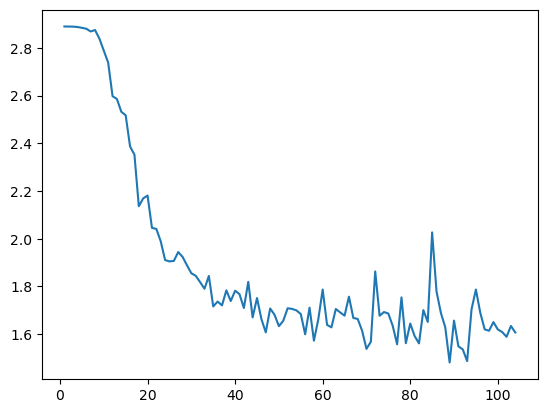

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_10102/3690815102.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_10102/3690815102.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


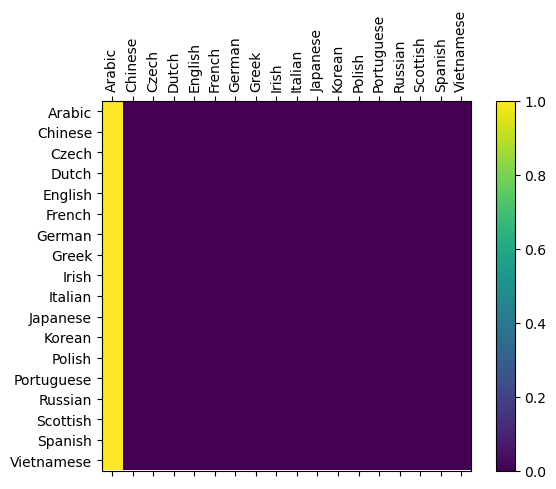

In [25]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000



# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(rnn2, line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [26]:
def predict(input_line, n_predictions=3):
    print('\n%s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            predictions.append([value, all_categories[category_index]])
        
        print(predictions[0][1])

In [27]:
predict('Touka')


Touka


TypeError: evaluate() missing 1 required positional argument: 'line_tensor'